## Load Data

In [29]:
import json
import string
import matplotlib.pyplot as plt 
import json_lines
import itertools

with open('result.jl', 'rb') as f:
    entities = [x for x in json_lines.reader(f)]
    stories = [x for x in entities if str(x['pageType']) == "story"]
    reviews = [x for x in entities if str(x['pageType']) == "review"]
    users = [x for x in entities if str(x['pageType']) == "user"]
    
    print(len(stories),len(reviews),len(users))

2672 22865 742


## Display Sentiment chart

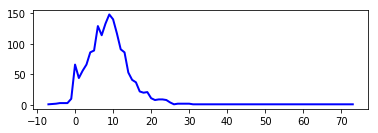

In [4]:
import operator
storyReviewDic = {}
for review in reviews:
    if(review['reviewOf'] not in storyReviewDic):
        storyReviewDic[review['reviewOf']] = []
    storyReviewDic[review['reviewOf']].append(review)

storySentimentScores = [sum([z['sentimentScore'] for z in y]) for x, y in storyReviewDic.items()]

buckets = {}

def updateBucket(x):
    buckets.setdefault(x, 0)
    buckets[x]+=1

[ updateBucket(int(x)) for x in storySentimentScores]

sortedBuckets = sorted(buckets.items(), key=operator.itemgetter(0))

fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.plot([x for x,y in sortedBuckets], [y for x,y in sortedBuckets], color='blue', lw=2)

#print(sum(storySentimentScore)/ len(storySentimentScore))

In [5]:
sum(storySentimentScores)/len(storySentimentScores)

9.344541108404393

## Create Adjacency Matrix

In [28]:
import numpy as np
idDict = {}
idCnt = 0

for x in users:
    if(x['name'] in idDict):
        continue;
    idDict[idCnt] = x['name']
    idCnt += 1

nameToIdDict = {v: k for k, v in idDict.items()}

userFavorites = {}
for user in users:
    userId = nameToIdDict[user['name']]
    userFavorites[userId] = []
    for favorite in user['favorites']:
        auther = favorite['favAuthor']
        if(auther in nameToIdDict):
            autherId = nameToIdDict[auther]
            if(autherId not in userFavorites[userId]):
                userFavorites[userId].append(autherId)
                
matrix = np.zeros([len(idDict), len(idDict)])

for userId, favorites in userFavorites.items():
    matrix[userId, userId] = 1
    for favId in favorites:
        matrix[userId, favId] = 1

## Try to get groups based on adjacency matrix

In [7]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

plt.figure(figsize=(12, 12))

random_state = 345345
pred = KMeans(n_clusters=5, random_state=random_state).fit_predict(matrix)

i = 0
clusters = {}
def makeCombined(x):
    global i
    row = [i,x]
    i += 1
    return row

usersWithCluster = [makeCombined(x) for x in pred]

import collections

clusters = collections.defaultdict(list)
for x in usersWithCluster:
    clusters[x[1]].append(x[0])
clusters = dict(clusters)
print([len(j) for i,j in clusters.items()])

<Figure size 864x864 with 0 Axes>

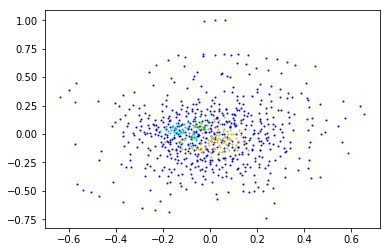

In [9]:
import matplotlib.pyplot as plt
import networkx as nx

colors = ['r', 'b', 'y', 'g', 'c', 'black', 'm', 'orange', 'grey', '']

def show_graph(adjacency_matrix):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    #print([x for x in edges])
    gr = nx.Graph()
    gr.add_edges_from(edges)
    #gr[0][1]['color'] = 'color'
    
    #nx.draw(gr, node_size=1)
    pos=nx.spring_layout(gr) 
    for i in range(5):
        nx.draw_networkx_nodes(gr,pos,nodelist = clusters[i], node_size=1, node_color=colors[i])
    #nx.draw_networkx_nodes(gr,pos,nodelist = clusters[1], node_size=1, node_color=colors[1])
    
    #nx.draw_networkx_edges(gr,pos,
    #                   width=1,alpha=0.5,edge_color='r')
    plt.show()
    
show_graph(matrix)


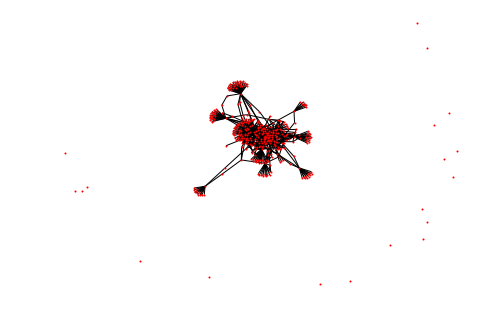

In [135]:
import matplotlib.pyplot as plt
import networkx as nx

def show_graph(adjacency_matrix):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    
    nx.draw(gr, node_size=1)
    plt.show()
    
show_graph(matrix)

## Make Character Graph

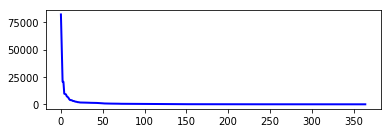

In [3]:
import collections
from collections import Counter
characterFreqs = Counter({})
for x in stories:
    characterFreqs += Counter(x['characters'])
characterFreqs = dict(characterFreqs)
#print(characterFreqs)
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.plot(sorted(characterFreqs.values(), reverse=True), color='blue', lw=2)

## making character matrix 

### get character ids

In [103]:
import collections
from collections import Counter
characterFreqs = Counter({})
for x in stories:
    characterFreqs += Counter(x['characters'])
characterFreqs = dict(characterFreqs)
charList = list(characterFreqs.keys())
idToChar = {charList.index(x): x for x in charList}
charToId = {x : charList.index(x) for x in charList}

### make the matrix

In [65]:
matrix = np.zeros([len(stories), len(charIds)])

storyId = 0
for story in stories:
    totalCharFreq = 0
    chars = dict(story['characters'])
    for char, freq in chars.items():
        if(char != 'Harry Potter'):
            totalCharFreq += freq
    for char, freq in chars.items():
        if(char != 'Harry Potter'):
            matrix[storyId][charToId[char]] = freq / totalCharFreq
        else:
            matrix[storyId][charToId[char]] = 0
    storyId += 1

[[0.         0.08024691 0.14197531 ... 0.         0.         0.        ]
 [0.         0.28205128 0.01282051 ... 0.         0.         0.        ]
 [0.         0.         0.00990099 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.04444444 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


### cluster it

In [72]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

random_state = 345345
pred = KMeans(n_clusters=10, random_state=random_state).fit_predict(matrix)

In [73]:
i = 0
clusters = {}
def makeCombined(x):
    global i
    row = [i,x]
    i += 1
    return row

storiesWithCluster = [makeCombined(x) for x in pred]
#print(sotriesWithCluster)


In [143]:
import collections

clusters = collections.defaultdict(list)
for x in storiesWithCluster:
    clusters[x[1]].append(x[0])
clusters = dict(clusters)
#print(clusters)
print([len(j) for i,j in clusters.items()])

[477, 250, 452, 92, 428, 414, 144, 196, 206, 13]


In [192]:
def showCluster(clusterId):
    clusterCharacterFreqs = Counter({})
    for storyId in clusters[clusterId]:
        charsInStory = np.where(matrix[storyId] > 0)
        if(len(charsInStory[0]) == 0):
            continue
        for charId in np.nditer(charsInStory):
            #print(matrix[storyId][charId], charId)
            clusterCharacterFreqs[int(charId)] += matrix[storyId][charId]
    clusterCharsWithFreq = [(x,y, idToChar[x])for x,y in clusterCharacterFreqs.items() if y > 5]
    
    print(sorted(clusterCharsWithFreq, key= lambda x: x[1],reverse=True))

print(clusters.keys())
    
for i in clusters.keys():
    print(len(clusters[i]))
    showCluster(i)

dict_keys([1, 4, 9, 3, 6, 2, 5, 0, 7, 8])
477
1 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34]
1 [ 1  2  4  5 11 13 16 24 28 30 35 36 37 38 39 40 41 42 43 44]
1 [ 1  2  4 16 17 28 39 44 51 52 57 58 59 60 61]
1 [ 1  4  5 11 17 18 19 23 28 30 41 43 51 52 53 54 56 80]
1 [ 1  2  4  6 11 16 23 27 28 30 32 33 39 42 43 51 52 53 59 66 67 69 74 81
 82]
1 [  1   2   4   5   9  11  16  17  21  23  24  27  28  30  41  42  50  51
  52  56  58  60  64  74  82  85  91  95  98 117 118 119 120 121 122 123]
1 [  2   3   4   5  11  17  23  24  25  26  28  32  34  39  51  58  76 104]
1 [  1   4  17  28  55  60  61  69  73  93  96 102 124]
1 [  1   2   4  11  12  14  16  17  24  25  28  38  41  52  56  60  74  76
  86  89  93 129]
1 [  1   2   4   5  11  16  17  27  28  33  34  43  51  60  61  69  90 104
 105 130]
1 [  1   2   4   5  12  16  17  26  28  30  34  42  48  59  86  92  93 124
 126 136 137]
1 [  1   2   4   5   6   8  11  12  16  17  20  

1 [  4   5  11  17  20  23  28  94 137 280]
1 [  1   2   4   5  11  12  16  17  25  28  41  44  52  56  58  59  60  93
 117 137 204 240]
1 [  1   2   3   4   5   8  11  12  14  16  17  23  24  25  26  28  30  32
  33  34  38  40  41  42  44  52  55  59  60  61  62  63  66  67  69  75
  76  86  92  93  96 102 104 105 107 128 129 131 133 145 154 183 185 195
 216 227 240 247 286 317 318]
1 [  1   2   4   5   7   8  11  12  16  17  26  28  34  36  38  42  44  49
  61  73  74  77 126 143 145 245]
1 [  1   4   5   6   7   8  11  16  17  21  24  28  30  32  34  38  40  42
  43  55  58  60  61  70  73  74  78  82  95 111 117 123 132 136 140 159
 162 164 166 206 211 221 270 281 315 353]
1 [  1   2   4  11  16  28  32 232]
1 [  1   4   5  11  25  28  30  39  62  63 149 223 249 255 321 331]
1 [  4   5  12  28  41  52  56  59 128]
1 [  1   2   3   4   5   6   8  11  14  23  28  42  61  66  67  99 213 247
 276 290]
1 [  1   2   4   5  11  12  16  17  23  24  27  28  30  33  34  42  51  64
  95  97 

1 [  4   5   6   7   8  11  12  16  27  28  38  53  66  67  83 134]
1 [  1   4  11  12  16  27  28  39  51  61  65  74  95  98 123 141 143 164
 170 189 203]
1 [ 14  16  17  25  28  38  39  42  74 145 185]
1 [ 4  5  6  7 11 14 16 17 28 38 40 42 51]
1 [  4   6  11  12  16  17  20  23  26  28  39  51  86  98 102 124 137 170
 204]
1 [  1   2   4   5   6   7   8  11  16  17  21  24  26  27  28  30  31  32
  33  34  38  42  51  53  54  61  78  85 102 104 116 117 123 129 137 154
 164 207 208 209 210]
1 [  2   4   5  16  17  18  19  23  24  28  30  33  44  51  64  85 117 211
 216]
1 [ 1  4  5  8 11 16 17 24 25 28 44 52 56 60]
1 [  1   2   4  11  14  16  17  24  28  42  43  73  89  93 102]
1 [  2   4   5   6  11  12  16  17  20  24  28  38  39  42  58  68  96 142
 181 187 224]
1 [ 4  5  6  7 11 12 16 17 25 28 30 38 39 48 67]
1 [  4   5   6  11  16  17  25  28  32  38  39  45  51 128 166 205]
1 [  4   6  11  12  14  16  17  25  28  32  38  45  51  66 128 137 181 204
 226]
1 [  4  12  16  27  28 

  51  55  58  61  66  82 100 117 145 146 234 235]
1 [  1   4   5   6   8  11  12  16  17  18  19  21  25  28  30  34  38  42
  43  44  49  53  61  74 128 142 144]
1 [  4   5  11  12  16  17  28  30  39  93 145]
1 [  4   8  16  17  20  24  25  28  30  44 102]
1 [  4   5   6  11  12  14  16  28  40  47  68 137]
1 [  4   5  11  16  17  23  26  28  30  31  42  44  51  55  59  60  64  85
 117 123 180 185]
1 [  1   2   3   4   5  12  13  16  17  18  19  23  24  26  28  30  34  36
  38  42  43  49  51  59  61  69  83  90  97 102 142 160 194]
1 [  1   2   5  16  17  28  61  85 126]
1 [  4   5   6  11  12  16  17  23  26  28  93 110 124 163]
[(16, 82.09099362254052, 'Hermione Granger'), (28, 36.75073281126044, 'Ron weasley'), (4, 15.302808139837232, 'Cho Chang'), (1, 6.7241811593325655, 'Albus Dumbledore'), (11, 6.093062448619082, 'Fat Friar'), (12, 6.042792948394037, 'Ginny weasley'), (2, 5.322669439455287, 'Voldemort'), (6, 5.115496730581783, 'Draco Malfoy')]
452
1 [ 4  8 11 17 21 25 27 28 32

ValueError: Iteration of zero-sized operands is not enabled

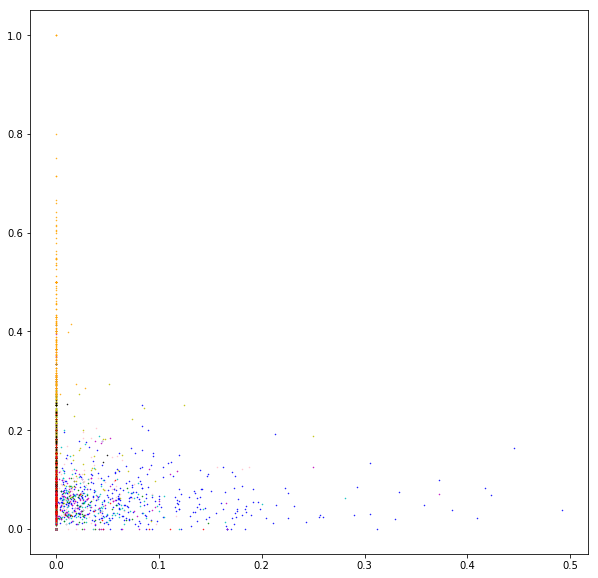

In [137]:
import matplotlib.pyplot as plt
import networkx as nx

colors = ['r', 'b', 'y', 'g', 'c', 'black', 'm', 'orange', 'grey', 'pink']

def plotCharacters(charId1, charId2, clusters):
    #print(charId1, charId2, clusters)
    #print(clusters)
    fig = plt.figure(figsize=[10,10])
    ax = fig.add_subplot(1, 1, 1)
    for clusterId, cluster in clusters.items():
        X = []
        Y = []
        for storyId in cluster:
            X.append(matrix[storyId][charId1])
            Y.append(matrix[storyId][charId2])
        ax.scatter(X,Y, color=colors[clusterId], s=.25)
            
plotCharacters(2,4, clusters)